# INSY 695 - Base Models 

In [2]:
import pandas as pd
import numpy as np
import os
import platform as pf
from IPython.display import display # Display data
pd.options.mode.chained_assignment = None  # default='warn'

#comment
#packages for time series
import warnings
import itertools    
import statsmodels.api as sm

#Richard was here
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import math
from scipy import stats

plt.style.use('fivethirtyeight')

In /Users/Rgao/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/Rgao/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/Rgao/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## 1. Load Data 

In [4]:
cwd = os.getcwd()
os_type = pf.system()


if os_type == 'Windows':
    df = pd.read_csv(cwd + r'\montreal.csv', sep=',\s,', delimiter=',', skipinitialspace=True)
else:
    df = pd.read_csv('../data/processed/montreal.csv', sep=',\s,', delimiter=',', skipinitialspace=True)
    

#need to specify datetime[ns] or else the rest will not run 
df['datetime'] = df['datetime'].astype('datetime64[ns]')

In [5]:
weather_df = df[['datetime', 'Temperature']].set_index('datetime')
weather_df

,Temperature
datetime,
2012-10-01 13:00:00,285.830000
2012-10-01 14:00:00,285.834650
2012-10-01 15:00:00,285.847790
2012-10-01 16:00:00,285.860929
2012-10-01 17:00:00,285.874069
...,...
2017-11-29 20:00:00,275.130000
2017-11-29 21:00:00,274.130000
2017-11-29 22:00:00,273.480000


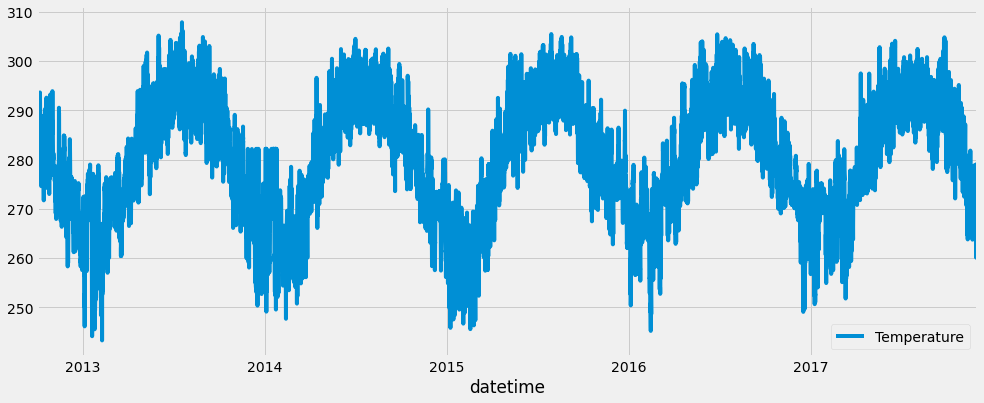

In [7]:
#plot current returns of part X resampled on a mean-returns month to month basis
weather_df.plot(figsize=(15, 6))
plt.show()

## MODEL 1. Seasonal ARIMA 

Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.Although the method can handle data with a trend, it does not support time series with a seasonal component. An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA. It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

**STEP 1: Decompose returns into trend, seasonal, and residual**

Each time series can be decomposed into trend, seasonality, and noise

We can see from the upward trend and annual seasonality that the time series may not be stationary. ARIMA must be stationary (no trends, cycles, random walk, etc.) to work, meaning mean, variance, correlation is constant over time -- if not stationary, transform into period-by-period differences instead.

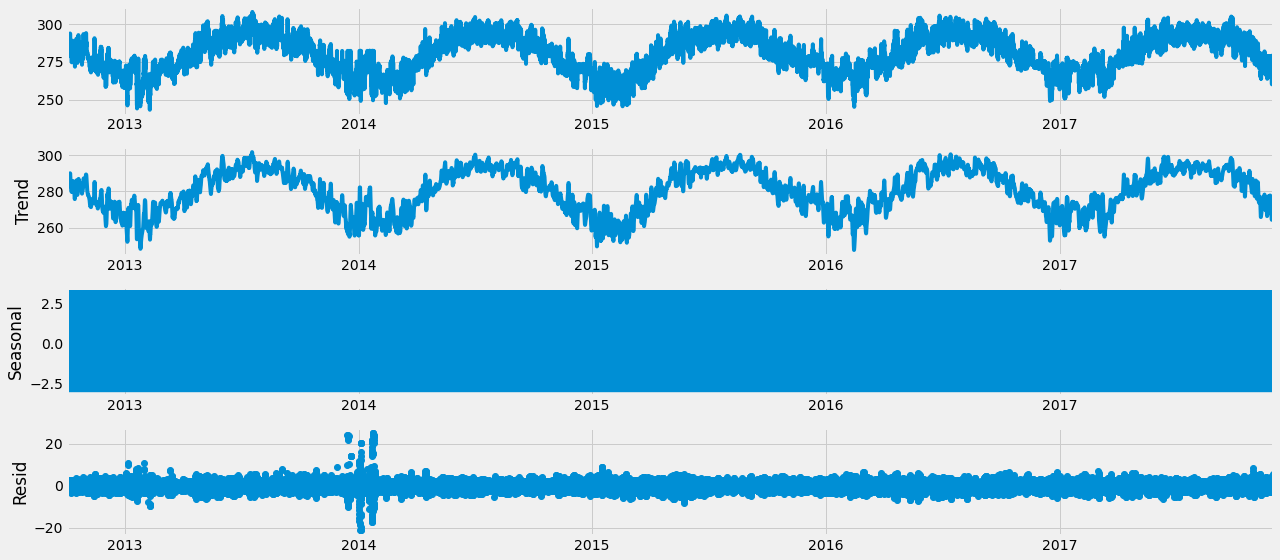

In [8]:
from pylab import rcParams

#decompose observed returns into trend, seasonal, and noise 
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(weather_df, model='additive')
fig = decomposition.plot()
plt.show()

**STEP 2: Run ADF (Augmented Dickey Fuller) Test to check for trend -- the null hypothesis is that the data is not stationary, so if p > 0.05, we can confirm the series is not stationary (there is a trend), and need to do first-order-differencing.**

The data is stationary if its mean, variance, and covariance remain constant over time. For instance, if the trend is upwards over time or the seasonal fluctuations get larger over time, then stationarity would be violated.

In [9]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(weather_df))

Results of Dickey-Fuller Test:
Test Statistic                -6.353630e+00
p-value                        2.574529e-08
#Lags Used                     5.600000e+01
Number of Observations Used    4.519500e+04
Critical Value (1%)           -3.430495e+00
Critical Value (5%)           -2.861604e+00
Critical Value (10%)          -2.566804e+00
dtype: float64
None


**STEP 3: Perform first order differencing**

Rerunning the test again after performing first order differencing confirms that the trend is now stationary.

Results of Dickey-Fuller Test:
Test Statistic                   -36.399538
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    45195.000000
Critical Value (1%)               -3.430495
Critical Value (5%)               -2.861604
Critical Value (10%)              -2.566804
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                   -39.010885
p-value                            0.000000
#Lags Used                        56.000000
Number of Observations Used    45183.000000
Critical Value (1%)               -3.430495
Critical Value (5%)               -2.861604
Critical Value (10%)              -2.566804
dtype: float64
None


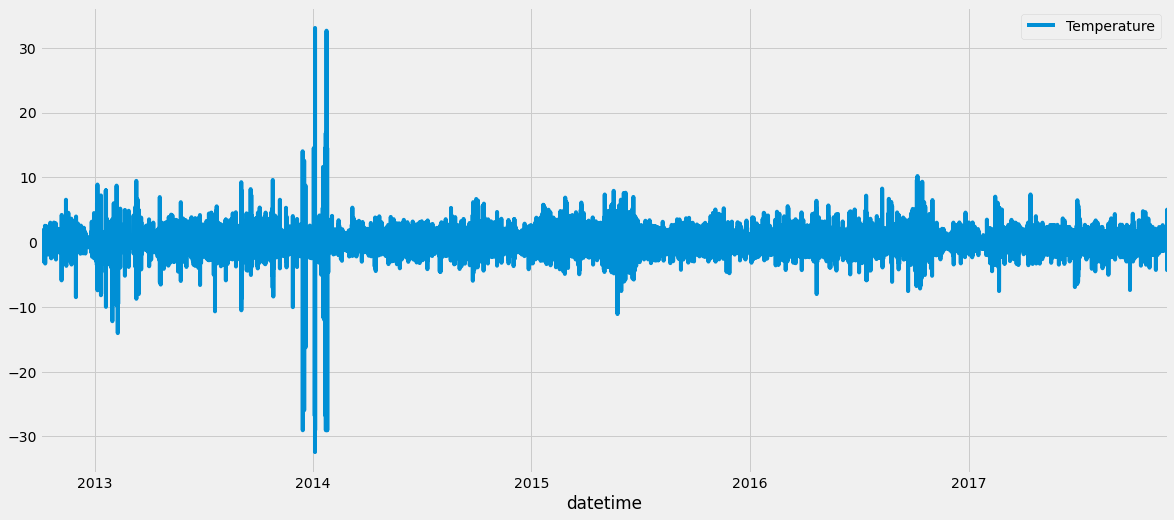

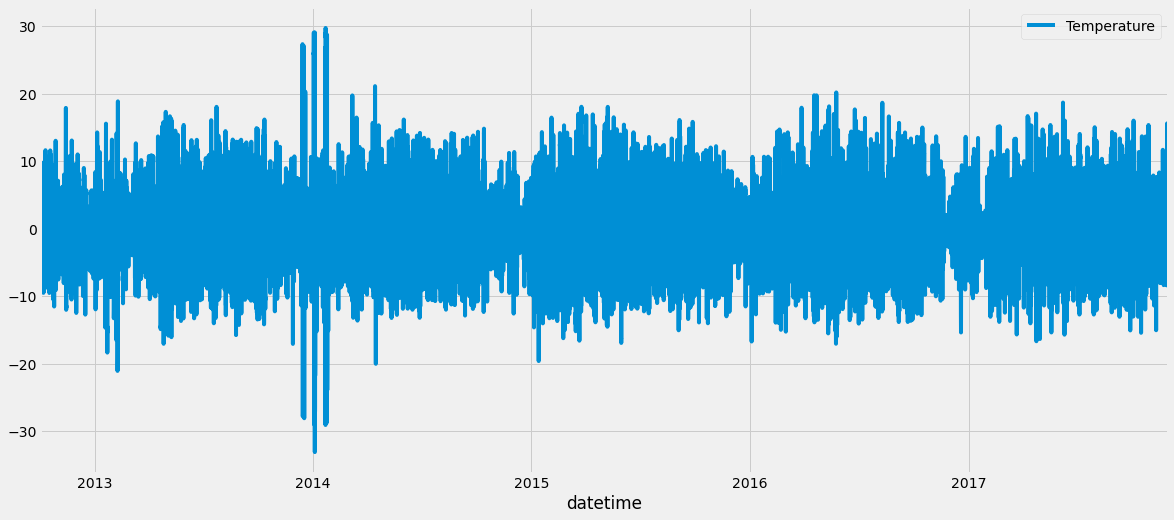

In [10]:
def differencing_func(y):
    #FIRST ORDER DIFFERENCING
    y_adj = y - y.shift(1)
    y_adj = y_adj.dropna()
    y_adj.plot()

    #SEASONAL DIFFERENCING 
    y_adj2 = y - y.shift(12)
    y_adj2 = y_adj2.dropna()
    y_adj2.plot()

    print(adf_test(y_adj))
    print(adf_test(y_adj2))
    
differencing_func(weather_df)

**Step 4: Plot ACF and PACF**

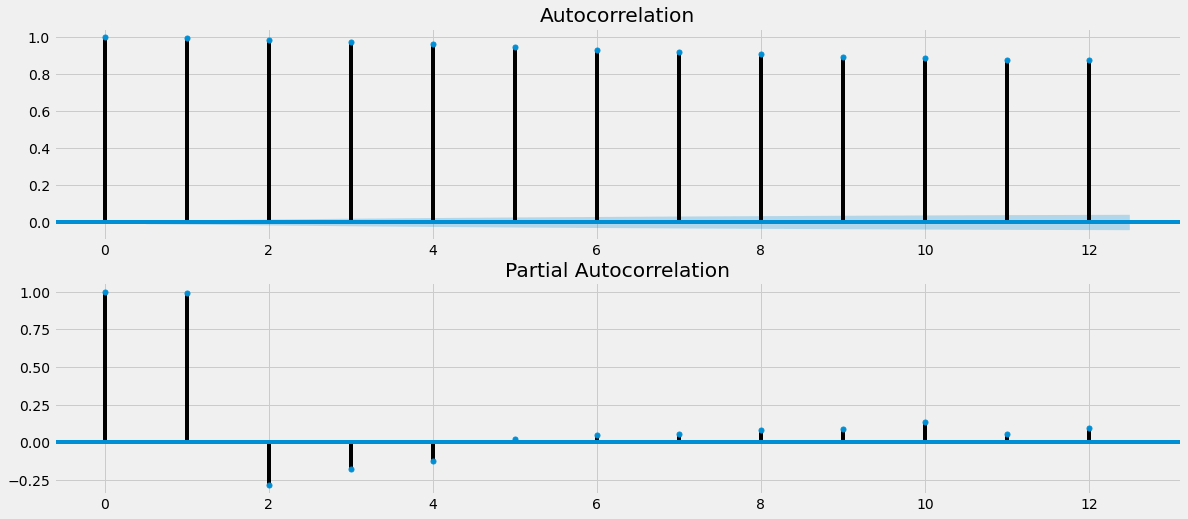

In [11]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(weather_df, lags=12, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(weather_df, lags=12, ax=ax[1])
plt.show()

**STEP 5: Specify SARIMA(p,d,q)*(P,D,Q,s)** 
- **p and seasonal P** = number of AUTOREGRESSIVE terms (lags of the stationarized series). It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- **d and seasonal D**: DIFFERENCING that must be done to stationarize the series. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
- **q and seasonal Q**: indicate number of MOVING AVERAGE terms -- lags of the forecast errors. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
- **s**: seasonal length in the data

- (p,q,d) are the non seasonal parameters and (P,Q,D) follow the same definition but are applied to the seasonal component.

This process of gridsearch will let the model automatically find the best parameters to make the ARIMA stationary. We use gridsearch since we are unsure of the actual parameters!

In [24]:
#since we are doing a seasonal ARIMA, we must specify parameters for ARIMA and SARIMA

#create combinations of ARIMA parameters
p = d = q = range(0, 2)
s = (1,12)

#create combinations of non-seasonal parameters 
pdq = list(itertools.product(p, d, q))

#create combinations for seasonal parameters -- 12 for monthly data
seasonal_pdq = list(itertools.product(p,d,q,s))


#print out sample of results
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 1, 1)
SARIMAX: (0, 1, 0) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 1)


In [25]:
grid_search = pd.DataFrame(columns = ['param', 'param_seasonal', 'AIC'])

warnings.filterwarnings("ignore") # specify to ignore warning messages
#loop through parameters and seasonal parameters and perform a grid search
for param in pdq: 
    for param_seasonal in seasonal_pdq: 
        try:
            model = sm.tsa.statespace.SARIMAX(weather_df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = model.fit(max_iter = 50, method = 'powell') #optimizer method 
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #append results to grid search df 
            grid_search = grid_search.append({'param': param, 'param_seasonal': param_seasonal, 'AIC': results.aic}, ignore_index=True)
        
        except:
            continue

Optimization terminated successfully.
         Current function value: 7.055861
         Iterations: 1
         Function evaluations: 19
SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:638585.6069744178
Optimization terminated successfully.
         Current function value: 6.423050
         Iterations: 2
         Function evaluations: 53
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:581315.6948893664
Optimization terminated successfully.
         Current function value: 3.204125
         Iterations: 1
         Function evaluations: 12
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:289988.1705698968
Optimization terminated successfully.
         Current function value: 3.009884
         Iterations: 2
         Function evaluations: 47
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:272410.5551225958
Optimization terminated successfully.
         Current function value: 3.205940
         Iterations: 1
         Function evaluations: 25
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:290154.4098362204
Optimization terminated successfully.
  

In [26]:
#extract the best parameters for model
best_param =  grid_search.sort_values(by = 'AIC').reset_index()['param'][0]
best_seasonal_param = grid_search.sort_values(by = 'AIC').reset_index()['param_seasonal'][0]
grid_search.sort_values(by = 'AIC').reset_index()

,index,param,param_seasonal,AIC
0,36,"(1, 0, 0)","(1, 0, 0, 12)",58.355520
1,53,"(1, 1, 0)","(1, 0, 1, 12)",134673.074037
2,29,"(0, 1, 1)","(1, 0, 1, 12)",134703.562331
3,21,"(0, 1, 0)","(1, 0, 1, 12)",134971.787903
4,37,"(1, 0, 0)","(1, 0, 1, 12)",134999.056645
...,...,...,...,...
59,4,"(0, 0, 0)","(1, 0, 0, 12)",290154.409836
60,9,"(0, 0, 1)","(0, 0, 1, 12)",518965.454076
61,8,"(0, 0, 1)","(0, 0, 0, 12)",576150.381568
62,1,"(0, 0, 0)","(0, 0, 1, 12)",581315.694889


**STEP 6: Run SARIMAX**

In [ ]:
#Lowest AIC Value: ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:122.9976149247615
#this adds exogenous data such as seasonality to the ARIMA model 
model = sm.tsa.statespace.SARIMAX(y,
                                order= best_param,
                                seasonal_order=best_seasonal_param,
                                enforce_stationarity=False,    #defaults, but not necessary
                                enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

**Check Model Fit** 
- Residuals: should be uncorrelated with a mean of 0, if there are correlations, there is information in them that should be used in computing forecasting. We can see that there is no correlation and zero mean.
- Correlogram: residuals have relatively low corerlation with lagged versions of itself

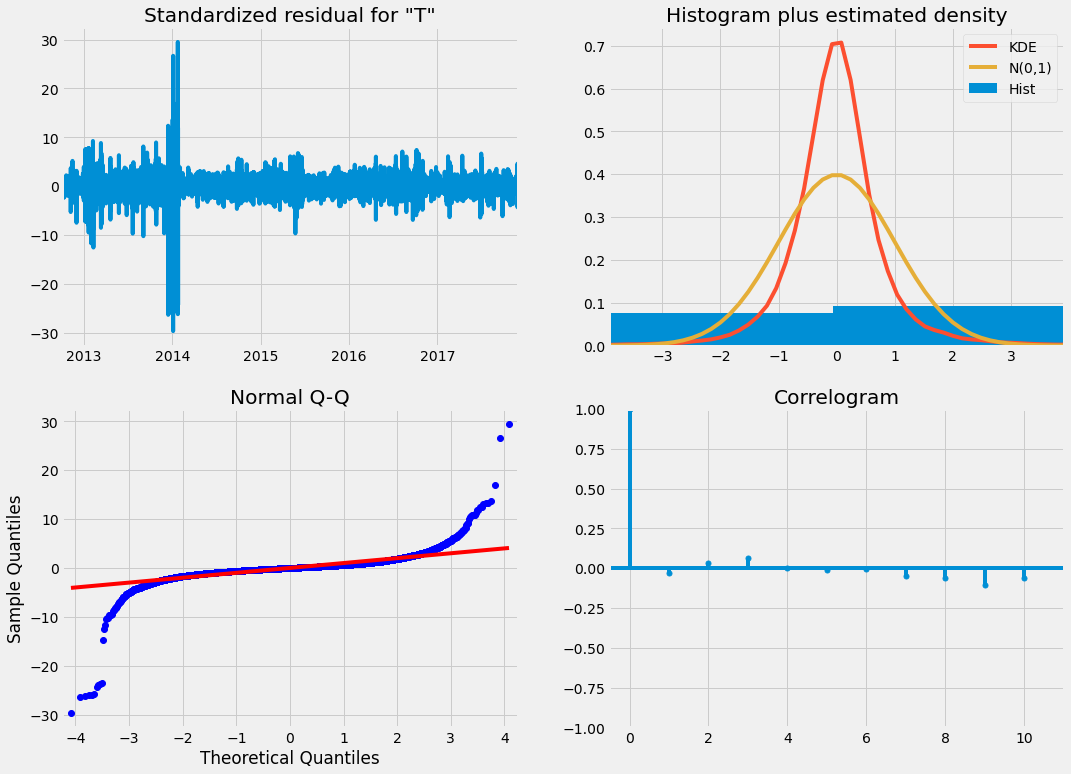

In [27]:
results.plot_diagnostics(figsize=(16, 12))
plt.show()

**STEP 7: Generate Predictions**

- dynamic: True = uses data from predicted points to generate future forecasts; False = generates one step ahead forecasts, i.e. uses only past data that we have to generate predicted forecasts
    - If we are only generating predictions for one month, then this should not matter

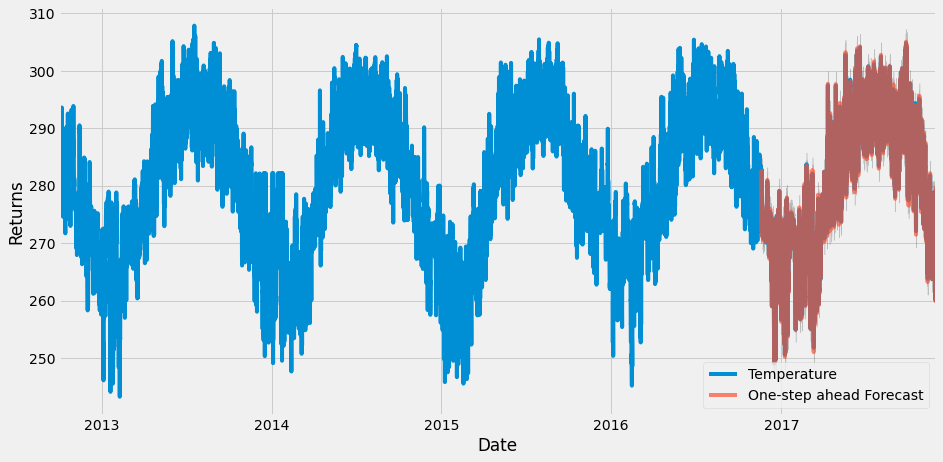

In [81]:
#user can set predicted values to when they want the prediction to start 
prediction_start_date = weather_df.iloc[int(len(weather_df)*0.80)].name
#predict to the end of the dataset 
prediction_end_date = pd.to_datetime(weather_df.index[-1])



#generate predicted results and store 
pred = results.get_prediction(start=prediction_start_date, end = prediction_end_date, dynamic=False)

#predicted vs truth for time period in question -- if the forecast is negative, change to 0 
predicted = pred.predicted_mean
predicted[predicted <0] = 0

observed = weather_df[prediction_start_date:]
#confidence interval
ci = pred.conf_int()
ci[ci <0] = 0

#plot real against predicted values
ax = weather_df.plot(label='observed')
predicted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
plt.legend()
plt.show()

In [82]:
ts_results = pd.DataFrame({'Predicted': predicted.values, 'CI Lower': ci['lower Temperature'], 'CI Upper': ci['upper Temperature'], 'Observed': observed['Temperature'].values})

#get RMSE -- calculate afterwards due to zeroing
ts_results['RMSE'] = np.sqrt((ts_results['Predicted'] - ts_results['Observed'].values)**2)
        
#RMSE of the entire prediction period 
RMSE_total = ts_results['RMSE'].mean()
RMSE_total

0.5732114105008564

In [83]:
ts_results.head(20).style.background_gradient(cmap='inferno')

,Predicted,CI Lower,CI Upper,Observed,RMSE
2016-11-17 22:00:00,282.646626,280.434067,284.859184,281.470000,1.176626
2016-11-17 23:00:00,280.889199,278.676640,283.101757,280.480000,0.409199
2016-11-18 00:00:00,279.961020,277.748461,282.173578,279.800000,0.161020
2016-11-18 01:00:00,279.895441,277.682882,282.107999,278.780000,1.115441
2016-11-18 02:00:00,278.694377,276.481819,280.906936,278.450000,0.244377
2016-11-18 03:00:00,278.300677,276.088119,280.513236,277.450000,0.850677
2016-11-18 04:00:00,277.023328,274.810769,279.235886,276.790000,0.233328
2016-11-18 05:00:00,276.608165,274.395607,278.820724,275.800000,0.808165
2016-11-18 06:00:00,275.545788,273.333230,277.758347,274.460000,1.085788
2016-11-18 07:00:00,273.914800,271.702241,276.127359,274.070000,0.155200


## MODEL 2. AutoARIMA


AutoARIMA is the least-specific base ARIMA model to generate a baseline prediction.

Usually, in the basic ARIMA model, we need to provide the p,d, and q values which are essential. We use statistical techniques to generate these values by performing the difference to eliminate the non-stationarity and plotting ACF and PACF graphs. In Auto ARIMA, the model itself will generate the optimal p, d, and q values which would be suitable for the data set to provide better forecasting.

**NOTE: AUTOARIMA CRASHES DUE TO DATA SIZE -- NOT CONTINUED** 

In [10]:
from pmdarima.utils import tsdisplay 
from pmdarima.arima import auto_arima
import pmdarima as pm

/opt/anaconda3/lib/python3.7/site-packages/pmdarima/utils/visualization.py:222: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


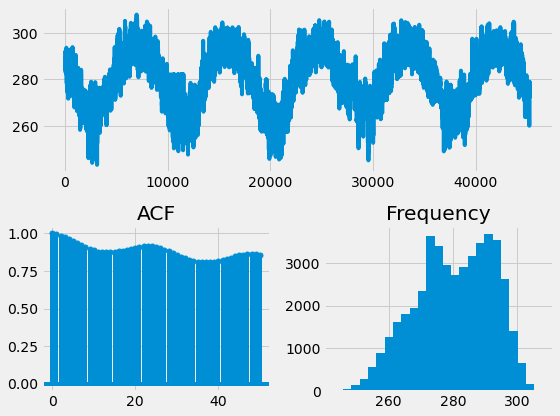

In [11]:
from pmdarima.utils import tsdisplay 
tsdisplay(weather_df)

## MODEL 3. GAM using FbProphet 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

According to FB's paper, FbProphet is a decomposable time-series with 3 main components: trend, seasonality, and holidays. FbProphet is specified similar to a generalized additive model (GAM) -- which are regression models with potential non-linear smoothers applied to the regressors. IT can decompose easily and accomodate new components when they are introduced -- i.e. if a new source of seasonality is identified. Since GAM frames the forecating problem as a curve fitting exercise, it is different from ARIMA that accounts for the temporal dependence structure in the data -- so it is inferentially weaker than a generative model such as ARIMA. However, it is more flexible (can accomodate seasonality with multiple periods), measurements do not need to be regularly spaced (so missing values do not need to be interpolated), and fitting is faster.

https://peerj.com/preprints/3190/
https://facebook.github.io/prophet/

In [84]:
from fbprophet import Prophet

In [85]:
#Reformat to FbProphet Format
y_prophet = pd.DataFrame({'ds': weather_df.index, 'y': weather_df['Temperature'].values}).reset_index().drop('index', axis = 1)
y_prophet

,ds,y
0,2012-10-01 13:00:00,285.830000
1,2012-10-01 14:00:00,285.834650
2,2012-10-01 15:00:00,285.847790
3,2012-10-01 16:00:00,285.860929
4,2012-10-01 17:00:00,285.874069
...,...,...
45247,2017-11-29 20:00:00,275.130000
45248,2017-11-29 21:00:00,274.130000
45249,2017-11-29 22:00:00,273.480000
45250,2017-11-29 23:00:00,272.480000


In [100]:
#split data 
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(y_prophet)*0.80)
train, test = train_test_split(y_prophet, split_len)

In [101]:
model = Prophet(yearly_seasonality = True, interval_width=0.95)
model.fit(train)

#in prophet, if you pass in historical dates it will provide an in-sample fit
forecast = model.make_future_dataframe(periods = len(test), freq = 'H')

results_df = model.predict(forecast)

In [102]:
#filter results down to test-dataset only 
results_filtered = results_df[['ds','yhat','yhat_lower','yhat_upper']].iloc[split_len:]

In [103]:
ts_results = pd.DataFrame({'Predicted' : results_filtered['yhat'].values, 'CI Lower': results_filtered['yhat_lower'].values, 'CI Upper':results_filtered['yhat_upper'].values , 'Observed': test['y'].values}, index = test['ds'])
ts_results[ts_results <0] = 0

ts_results['RMSE'] = np.sqrt((ts_results['Predicted'] - ts_results['Observed'])**2)
RMSE_total = ts_results['RMSE'].mean()
RMSE_total

4.683666564629104

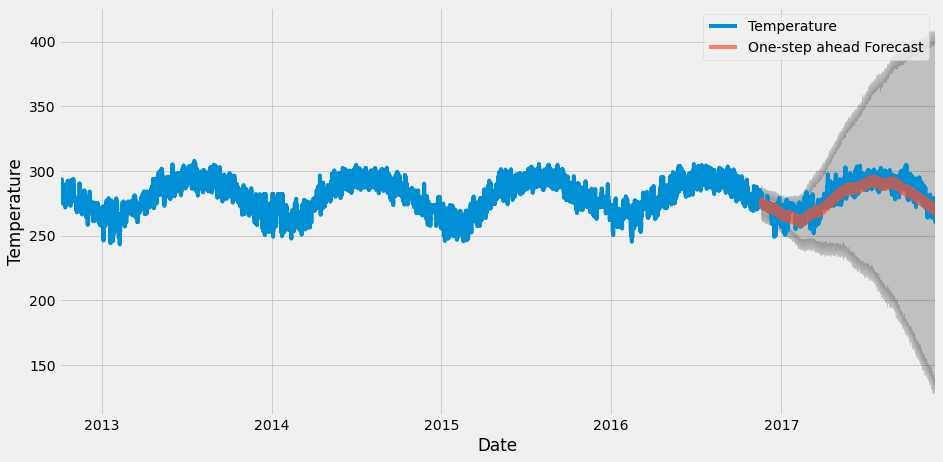

In [105]:
#plot real against predicted values
ax = weather_df.plot(label='observed')
ts_results['Predicted'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))


ax.fill_between(ts_results.index,
                ts_results['CI Lower'],
                ts_results['CI Upper'], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

In [108]:
ts_results.head(20).style.background_gradient(cmap='inferno')

,Predicted,CI Lower,CI Upper,Observed,RMSE
ds,,,,,
2016-11-17 22:00:00,278.264404,268.294696,287.842716,281.470000,3.205596
2016-11-17 23:00:00,277.576498,267.034180,285.857017,280.480000,2.903502
2016-11-18 00:00:00,276.810463,267.219977,286.755578,279.800000,2.989537
2016-11-18 01:00:00,276.072138,267.120876,285.922748,278.780000,2.707862
2016-11-18 02:00:00,275.416487,265.937384,284.862844,278.450000,3.033513
2016-11-18 03:00:00,274.854153,264.969009,285.047779,277.450000,2.595847
2016-11-18 04:00:00,274.375155,264.148813,283.211552,276.790000,2.414845
2016-11-18 05:00:00,273.961642,263.968465,283.191864,275.800000,1.838358
2016-11-18 06:00:00,273.586746,264.703355,283.137259,274.460000,0.873254


## 3. XGBOOST & RF

Now, we will try to transform the time-series data into a supervised learning problem by testing a variety of tree-based models.

In [13]:
ml_df = pd.DataFrame({'Temperature': weather_df['Temperature']}, index = weather_df.index)

In [14]:
#CREATE LAGGED ATTRIBUTES 

ml_df['date'] = ml_df.index
ml_df['month'] = ml_df['date'].dt.day
ml_df['month'] = ml_df['date'].dt.month
ml_df['year'] = ml_df['date'].dt.year

ml_df['lag1'] = ml_df['Temperature'].shift(periods = 1, fill_value = 0)
ml_df['lag2'] = ml_df['Temperature'].shift(periods = 2, fill_value = 0)
ml_df['lag12'] = ml_df['Temperature'].shift(periods = 12, fill_value = 0)
ml_df['lag24'] = ml_df['Temperature'].shift(periods = 24, fill_value = 0)

ml_df['avg_returns'] = 0 
for i in range(1, len(ml_df)):
    ml_df['avg_returns'][i] = ml_df['lag1'][:i+1].mean()
    

ml_df.drop('date', axis = 1, inplace = True)

#we have to eliminate all those with 0s
ml_df = ml_df[ml_df['lag24'] != 0]

In [15]:
X = ml_df.iloc[:,1:]
y = ml_df[['Temperature']]

In [19]:
type(X['lag1'][0])

numpy.float64

In [71]:
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(weather_df)*0.80)

X_train, X_test = train_test_split(X, split_len)
y_train, y_test = train_test_split(y, split_len)

In [12]:
X_test

NameError: name 'X_test' is not defined

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

### XGB Regressor

In [73]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) 

pred = xgb_model.predict(X_test)

In [74]:
ts_results = pd.DataFrame({'Predicted': pred, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

0.6105905131192384

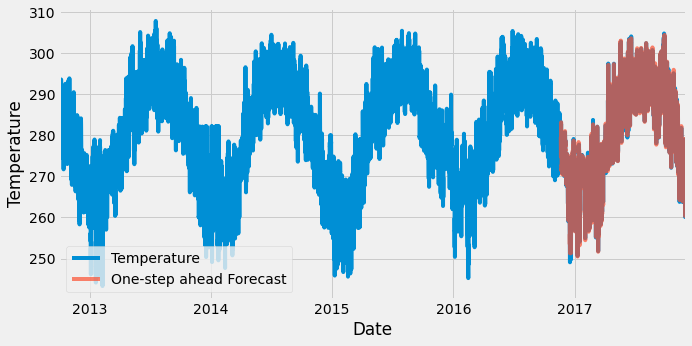

In [75]:
#plot real against predicted values
ax = weather_df.plot(label='observed')
ts_results['Predicted'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

In [76]:
ts_results.head(20).style.background_gradient(cmap='inferno')

,Predicted,Observed,RMSE
datetime,,,
2016-11-18 22:00:00,279.593292,279.150000,0.443292
2016-11-18 23:00:00,278.821808,277.840000,0.981808
2016-11-19 00:00:00,277.596008,278.150000,0.553992
2016-11-19 01:00:00,278.580017,278.150000,0.430017
2016-11-19 02:00:00,278.593811,277.440000,1.153811
2016-11-19 03:00:00,277.390137,277.460000,0.069863
2016-11-19 04:00:00,277.496918,277.150000,0.346918
2016-11-19 05:00:00,276.556122,276.460000,0.096122
2016-11-19 06:00:00,276.503723,275.800000,0.703723


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

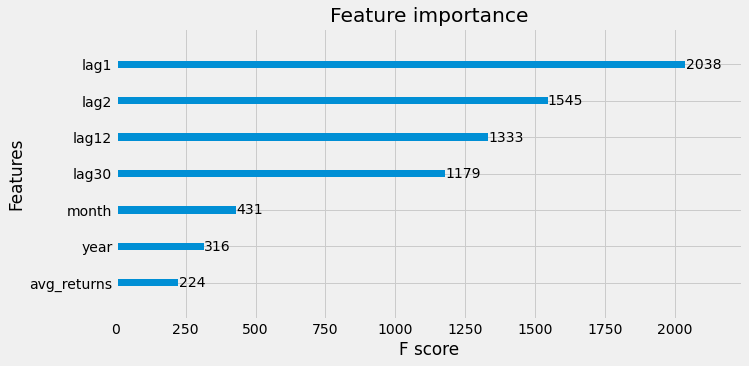

In [77]:
plt.figure(figsize=(10,5))
xgb.plot_importance(reg, ax=plt.gca())

## Other Models

In [78]:
#Import models' packages
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error


#Regression Models
regression_models = [['Linear Regression',LinearRegression()], 
                     ['RF regressor',RandomForestRegressor()], 
                     ['GBT',GradientBoostingRegressor()],
                     ['LASSO', Lasso()],
                     ['Ridge', Ridge()]]
                     

MSEs = []
MAEs = []
RMSEs = []
Models = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Lasso', 'Ridge']

for name, model in regression_models: 
    print('Model = ', name)
    model.fit(X_train, y_train.values.ravel())
    y_test_pred = model.predict(X_test)
    
    MSE = mean_squared_error(y_test, y_test_pred)
    MAE = mean_absolute_error(y_test, y_test_pred)
    RMSE = np.sqrt(MSE)
    
    MSEs.append(MSE)
    MAEs.append(MAE)
    RMSEs.append(RMSE)
    print("MSE: ", MSE)
    print("RMSE: ", RMSE)
    print("MAE: ", MAE)
    print("-" * 19)

Model =  Linear Regression
MSE:  0.7809309598028661
RMSE:  0.8837029816645784
MAE:  0.6228986473492573
-------------------
Model =  RF regressor
MSE:  0.7534193335870312
RMSE:  0.8679973119699341
MAE:  0.6115819948592927
-------------------
Model =  GBT
MSE:  0.8679987114603377
RMSE:  0.9316644843828371
MAE:  0.6634573843357924
-------------------
Model =  LASSO
MSE:  1.8717026436818152
RMSE:  1.36810183966027
MAE:  1.0725981902221209
-------------------
Model =  Ridge
MSE:  0.7826333252155185
RMSE:  0.8846656573053565
MAE:  0.6238340232355322
-------------------
